# 1. Áî¢Áîü GaussPy Êì¨ÂêàÊâÄÈúÄÁöÑÂÉèÁ¥†ÂÖâË≠úËº∏ÂÖ•Ê™î

In [ ]:
def prepare_gausspy_input_per_pixel(
    cube_file, v1, v2, x1, x2, y1, y2, output_pickle='spectrum_for_gausspy.pickle'
):
    import numpy as np
    import pickle
    from astropy.io import fits

    # ËÆÄÂèñ FITS Ë≥áÊñô
    data = fits.getdata(cube_file)[0]
    header = fits.getheader(cube_file)
    subcube = data[v1:v2, y1:y2, x1:x2]  # shape: (channels, y, x)

    # È†ªÈÅì ‚Üí ÈÄüÂ∫¶Ôºàradio conventionÔºâ
    CRVAL3 = header['CRVAL3']
    CDELT3 = header['CDELT3']
    CRPIX3 = header['CRPIX3']
    N_full = header['NAXIS3']

    chan_all = np.arange(N_full)
    velo_all = CRVAL3 + (chan_all + 1 - CRPIX3) * CDELT3  # m/s
    velo_all_kms = velo_all / 1e3 # Â∞áÈÄüÂ∫¶ËΩâÊèõÁÇ∫ km/s
    velo = velo_all_kms[v1:v2]

    # ÊØèÂÄã pixel ‰∏ÄÊ¢ùÂÖâË≠ú
    ny, nx = subcube.shape[1:]
    spectra_list = []
    errors_list = []

    for j in range(ny):
        for i in range(nx):
            spec = subcube[:, j, i]
            rms = np.nanstd(spec)
            spectra_list.append(spec)
            errors_list.append(np.full_like(spec, rms))

    # ÂÑ≤Â≠òÁÇ∫ GaussPy Ëº∏ÂÖ•Ê†ºÂºè
    output = {
        'x_values': [velo] * len(spectra_list),
        'data_list': spectra_list,
        'errors': errors_list
    }

    with open(output_pickle, 'wb') as f:
        pickle.dump(output, f)

    print(f"‚úÖ Â∑≤ÂÑ≤Â≠ò {len(spectra_list)} Ê¢ùÂÖâË≠úËá≥ {output_pickle}")

prepare_gausspy_input_per_pixel(
    cube_file="../datacubes/spw0.fits",
    v1=750, v2=950, x1=220, x2=240, y1=100, y2=120,
    output_pickle='spectrum_for_gausspy.pickle'
)

# 2. Âü∑Ë°å GaussPy phase two ÈõôÈöéÊÆµÈ´òÊñØÂàÜËß£

In [ ]:
def run_phase_two_gausspy_decomposition(
    input_pickle='spectrum_for_gausspy.pickle',
    output_pickle='gausspy_result.pickle',
    alpha1=2.0,
    alpha2=6.0,
    snr_thresh=3.0
):
    import pickle
    from gausspy.gp import GaussianDecomposer

    # ÂàùÂßãÂåñ
    g = GaussianDecomposer()

    # Ë®≠ÂÆöÁÇ∫ÈõôÈöéÊÆµÊ®°Âºè
    g.set('phase', 'two')
    g.set('alpha1', alpha1)
    g.set('alpha2', alpha2)
    g.set('SNR_thresh', [snr_thresh, snr_thresh])

    # Âü∑Ë°åÂàÜËß£
    print("üöÄ Âü∑Ë°å GaussPy phase='two' ÂàÜËß£ ...")
    result = g.batch_decomposition(input_pickle)

    # ÂÑ≤Â≠òÁµêÊûú
    with open(output_pickle, 'wb') as f:
        pickle.dump(result, f)

    print(f'ÈõôÈöéÊÆµÂàÜËß£ÂÆåÊàêÔºåÂÑ≤Â≠òÁÇ∫ {output_pickle}')
    print(f'ÂèØÁî®Ê¨Ñ‰ΩçÔºö{list(result.keys())}')

run_phase_two_gausspy_decomposition(
    input_pickle='spectrum_for_gausspy.pickle',
    output_pickle='gausspy_result.pickle',
    alpha1=2.0,
    alpha2=6.0,
    snr_thresh=3.0
)


# 3. Áµ±Ë®à GaussPy Êì¨ÂêàÊàêÂäüËàáÂ§±ÊïóÊï∏Èáè

In [ ]:
def count_successful_gausspy_fits(
    result_pickle='gausspy_result.pickle',
    subcube_shape=None  # ‰æãÂ¶Ç (ny, nx)ÔºåÂèØÈÅ∏ÔºåÁî®‰æÜÈÇÑÂéüÂ§±ÊïóÂÉèÁ¥†ÁöÑÁ©∫ÈñìÂ∫ßÊ®ô
):
    import pickle

    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    # ‰ΩøÁî®È†êË®≠Ê¨Ñ‰Ωç amplitudes_fit
    if 'amplitudes_fit' not in result:
        raise KeyError("‚ùå Êâæ‰∏çÂà∞ 'amplitudes_fit' Ê¨Ñ‰ΩçÔºåË´ãÁ¢∫Ë™çËº∏ÂÖ•ÊòØ GaussPy ÁöÑÁµêÊûú")

    amps_all = result['amplitudes_fit']
    n_total = len(amps_all)
    failed_indices = [i for i, amps in enumerate(amps_all) if amps is None or len(amps) == 0]
    n_success = n_total - len(failed_indices)
    success_rate = 100 * n_success / n_total if n_total > 0 else 0

    print(f"üîç Êì¨ÂêàÁ∏ΩÊï∏Ôºö{n_total}ÔºåÊàêÂäüÊï∏Ôºö{n_success}ÔºåÂ§±ÊïóÊï∏Ôºö{len(failed_indices)}")
    print(f"‚úÖ ÊàêÂäüÁéáÔºö{success_rate:.1f}%")

    if failed_indices:
        print(f"‚ùå Â§±Êïó index ÂÖ± {len(failed_indices)} Á≠Ü")
        if subcube_shape:
            ny, nx = subcube_shape
            failed_coords = [(i // nx, i % nx) for i in failed_indices]
            print("Â§±ÊïóÂ∫ßÊ®ô (y, x):")
            for yx in failed_coords:
                print(f" - {yx}")
            return failed_coords
        else:
            print(f"Â§±Êïó index: {failed_indices}")
            return failed_indices
    else:
        print("üéâ ÊâÄÊúâÂÉèÁ¥†Êì¨ÂêàÊàêÂäüÔºÅ")
        return []
        
count_successful_gausspy_fits(
    result_pickle='gausspy_result.pickle',
    subcube_shape=(20, 20)  # Ê†πÊìö prepare_gausspy_input_per_pixel ÁöÑËº∏ÂÖ•Ë®≠ÂÆö
)

# 4. Áπ™Ë£Ω GaussPy Êì¨ÂêàÁµêÊûúÔºàÊØèÊ¢ùÂÖâË≠úÔºâ

In [ ]:
def plot_gausspy_fits(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    max_plots=None,
    dpi=100
):
    """
    ‰∏ÄÂºµ‰∏ÄÂºµÁï´Âá∫ GaussPy Êì¨ÂêàÁµêÊûúÔºåÊ®ôÂá∫ÊØèÂÄãÈ´òÊñØÊàêÂàÜÁöÑ peak velocity„ÄÇ
    ÂÉÖ‰ΩøÁî®‰∏ÄËà¨Êì¨ÂêàÁµêÊûúÔºà‰∏çÂê´ EM fitÔºâ„ÄÇ
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    with open(data_pickle, 'rb') as f:
        data = pickle.load(f)
    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    x_all = data['x_values']
    y_all = data['data_list']
    amps_all = result['amplitudes_fit']
    means_all = result['means_fit']
    fwhms_all = result['fwhms_fit']

    n_result = len(amps_all)
    n_data = len(y_all)
    n_total = min(n_result, n_data)
    n_plotted = 0

    for i in range(n_total):
        if max_plots is not None and n_plotted >= max_plots:
            break

        amps = amps_all[i]
        means = means_all[i]
        fwhms = fwhms_all[i]

        if amps is None or len(amps) == 0:
            continue  # Êì¨ÂêàÂ§±ÊïóÔºåË∑≥ÈÅé

        x = x_all[i]
        y = y_all[i]
        stddevs = fwhms / (2 * np.sqrt(2 * np.log(2)))

        fit_total = np.zeros_like(x)
        gaussians = []

        for amp, mean, std in zip(amps, means, stddevs):
            gauss = amp * np.exp(-(x - mean)**2 / (2 * std**2))
            fit_total += gauss
            gaussians.append((gauss, mean, amp))

        # Áπ™Âúñ
        plt.figure(figsize=(10, 4), dpi=dpi)
        plt.plot(x, y, color='black', lw=1, label='Original Spectrum')
        plt.plot(x, fit_total, color='red', lw=2, label='Total Fit')

        colors = plt.cm.tab10(np.linspace(0, 1, len(gaussians)))

        for j, (g, mean, amp) in enumerate(gaussians):
            plt.plot(x, g, linestyle='--', color=colors[j % 10], alpha=0.8, label=f'Comp {j+1}')
            plt.axvline(mean, color=colors[j % 10], linestyle='-', linewidth=1)
            plt.text(mean, amp * 1.05, f'v = {mean:.1f} km/s',
                     rotation=90, ha='center', va='bottom', fontsize=8,
                     color=colors[j % 10], backgroundcolor='white')

        plt.title(f'Gaussian Fit - Spectrum #{i}', fontsize=12)
        plt.xlabel('Velocity (km/s)')
        plt.ylabel('Intensity')
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.legend(fontsize=8, loc='upper right')
        plt.tight_layout()
        plt.show()

        n_plotted += 1

    print(f"‚úÖ Â∑≤Áπ™Ë£Ω {n_plotted} Ê¢ùÊì¨ÂêàÊàêÂäüÁöÑÂÖâË≠úÔºàÊ®ôË®ò peak velocityÔºâ")

plot_gausspy_fits(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    max_plots=10,  # ÈôêÂà∂Áπ™Ë£ΩÂâç 10 Ê¢ùÂÖâË≠ú
    dpi=100
)

# 5. Â∞áÊâÄÊúâfitÂá∫ÁöÑÂÖâË≠úÁßªÂà∞rest frame ‰∏ä‰∏¶Áï´Âá∫

In [ ]:
def plot_gausspy_fits_all_restframe(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    max_plots=None,
    dpi=100
):
    """
    ‰∏ÄÂºµ‰∏ÄÂºµÁï´Âá∫ spectrum ÁöÑÊì¨ÂêàÁµêÊûúÔºå‰∏¶Â∞á‰∏ªÊàêÂàÜ peak Â∞çÈΩäËá≥ v = 0 km/s„ÄÇ
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    with open(data_pickle, 'rb') as f:
        data = pickle.load(f)
    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    x_all = data['x_values']
    y_all = data['data_list']
    amps_all = result['amplitudes_fit']
    means_all = result['means_fit']
    fwhms_all = result['fwhms_fit']

    n_result = len(amps_all)
    n_data = len(y_all)
    n_total = min(n_result, n_data)
    n_plotted = 0

    for i in range(n_total):
        if max_plots is not None and n_plotted >= max_plots:
            break

        amps = amps_all[i]
        means = means_all[i]
        fwhms = fwhms_all[i]

        if amps is None or len(amps) == 0:
            continue

        x_orig = x_all[i]
        y = y_all[i]

        # ÂèñÁ¨¨‰∏ÄÂÄãÊàêÂàÜÁöÑ peak velocity Áï∂‰Ωú rest frame ÂèÉËÄÉ
        v_peak = means[0]
        x_shifted = x_orig - v_peak
        means_shifted = [v - v_peak for v in means]

        stddevs = fwhms / (2 * np.sqrt(2 * np.log(2)))

        fit_total = np.zeros_like(x_orig)
        gaussians = []

        for amp, mean, std in zip(amps, means_shifted, stddevs):
            gauss = amp * np.exp(-(x_shifted - mean)**2 / (2 * std**2))
            fit_total += gauss
            gaussians.append((gauss, mean, amp))

        # Áï´Âúñ
        plt.figure(figsize=(10, 4), dpi=dpi)
        plt.plot(x_shifted, y, color='black', lw=1, label='Original Spectrum')
        plt.plot(x_shifted, fit_total, color='red', lw=2, label='Total Fit')

        colors = plt.cm.tab10(np.linspace(0, 1, len(gaussians)))

        for j, (g, mean, amp) in enumerate(gaussians):
            plt.plot(x_shifted, g, linestyle='--', color=colors[j % 10], alpha=0.8, label=f'Comp {j+1}')
            plt.axvline(mean, color=colors[j % 10], linestyle='-', linewidth=1)
            plt.text(mean, amp * 1.05, f'{mean:.1f} km/s',
                     rotation=90, ha='center', va='bottom', fontsize=8,
                     color=colors[j % 10], backgroundcolor='white')

        plt.title(f'Gaussian Fit (Rest Frame) - Spectrum #{i}', fontsize=12)
        plt.xlabel('Rest-frame Velocity (km/s)')
        plt.ylabel('Intensity')
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.legend(fontsize=8, loc='upper right')
        plt.tight_layout()
        plt.show()

        n_plotted += 1

    print(f"‚úÖ Â∑≤Áπ™Ë£Ω {n_plotted} Ê¢ùÂÖâË≠úÔºà‰∏ª peak Â∞çÈΩä v = 0 km/sÔºâ")

# plot_gausspy_fits_all_restframe(
#     data_pickle='spectrum_for_gausspy.pickle',
#     result_pickle='gausspy_result.pickle',
#     max_plots=10,  # ÈôêÂà∂Áπ™Ë£ΩÂâç 10 Ê¢ùÂÖâË≠ú
#     dpi=100
# )

# 6. Â∞á‰∏ªÊàêÂàÜÁßªÂà∞rest frame ‰∏ä‰∏¶ÁñäÂä†

/Users/ccc/opt/anaconda3/envs/gausspy/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/Users/ccc/opt/anaconda3/envs/gausspy/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


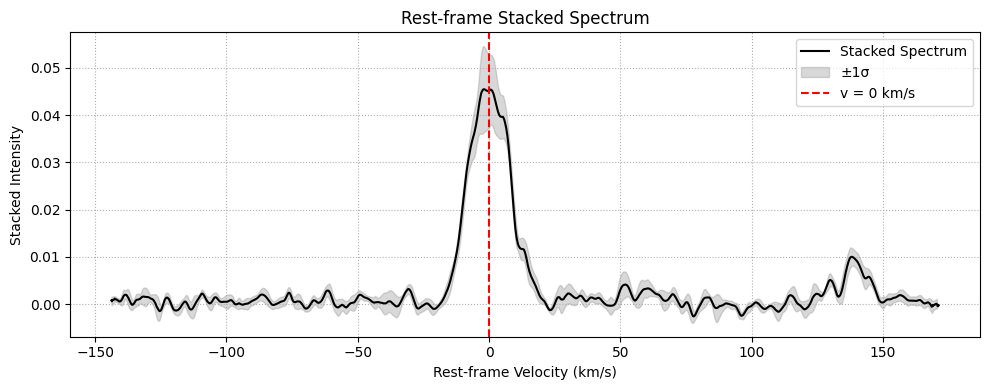

‚úÖ ÁñäÂä†ÂÆåÊàêÔºöÁ∏ΩÂÖâË≠ú 25ÔºåÊàêÂäü‰ΩøÁî® 23 Ê¢ùÔºà92.0%Ôºâ


In [ ]:
def stack_restframe_spectra(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    velocity_grid=None,
    v_range=(-50, 50),
    dv=0.2,
    normalize=False
):
    """
    ÁñäÂä†ÊâÄÊúâÊì¨ÂêàÊàêÂäüÁöÑÂÖâË≠úÔºåÂ∞á‰∏ªÊàêÂàÜÂ∞çÈΩäËá≥ v=0 km/sÔºåÊèêÂçá SNR„ÄÇ

    ÂèÉÊï∏Ôºö
        data_pickle: ÂÖâË≠úË≥áÊñôÔºàprepare_gausspy_input ÁöÑËº∏Âá∫Ôºâ
        result_pickle: GaussPy ÁöÑÂàÜËß£ÁµêÊûúÔºàrun_phase_two_gausspy_decomposition ÁöÑËº∏Âá∫Ôºâ
        velocity_grid: Ëá™Ë®ÇÁµ±‰∏ÄÈÄüÂ∫¶Ëª∏ÔºàËã•ÁÇ∫ None Ââá‰ΩøÁî® v_range Ëàá dv Âª∫Á´ãÔºâ
        v_range: È†êË®≠ÈÄüÂ∫¶ÁØÑÂúç (km/s)ÔºåÂ¶Ç (-50, 50)
        dv: ÈÄüÂ∫¶Ëß£ÊûêÂ∫¶ (km/s)
        normalize: ÊòØÂê¶Ê≠£Ë¶èÂåñÊØèÊ¢ùÂÖâË≠úÂÜçÈÄ≤Ë°åÁñäÂä†ÔºàÈÅøÂÖçÂÄãÂà•Âº∑Â∫¶‰∏ªÂ∞éÔºâ

    ÂõûÂÇ≥Ôºö
        v_grid: ÈÄüÂ∫¶Ëª∏ (km/s)
        mean_spec: ÁñäÂä†Âπ≥ÂùáÂÖâË≠ú
        std_spec: ÁñäÂä†Ê®ôÊ∫ñÂ∑ÆÔºà1œÉÔºâ
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d

    # === ËÆÄÂÖ•ÂÖâË≠úËàáÊì¨ÂêàË≥áÊñô ===
    with open(data_pickle, 'rb') as f:
        data = pickle.load(f)
    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    x_all = data['x_values']
    y_all = data['data_list']
    amps_all = result['amplitudes_fit']
    means_all = result['means_fit']

    # === ÂÆöÁæ©Áµ±‰∏ÄÈÄüÂ∫¶Ëª∏ ===
    if velocity_grid is None:
        v_grid = np.arange(v_range[0], v_range[1] + dv, dv)
    else:
        v_grid = velocity_grid

    stacked = []
    used_indices = []

    for i, (x, y, amps, means) in enumerate(zip(x_all, y_all, amps_all, means_all)):
        if amps is None or len(amps) == 0 or means is None:
            continue

        # ‰ΩøÁî®ÊúÄÂ§ß amplitude Â∞çÊáâÁöÑ‰∏≠ÂøÉ‰ΩúÁÇ∫Âπ≥ÁßªÂü∫Ê∫ñ
        idx_peak = np.argmax(amps)
        v_peak = means[idx_peak]
        x_shifted = x - v_peak  # ‰∏ªÊàêÂàÜÂ∞çÈΩäÂà∞ v = 0

        try:
            f_interp = interp1d(x_shifted, y, kind='linear', bounds_error=False, fill_value=np.nan)
            y_interp = f_interp(v_grid)
            if normalize:
                y_interp = y_interp / np.nanmax(np.abs(y_interp))
            stacked.append(y_interp)
            used_indices.append(i)
        except Exception:
            continue  # Ëã•ÊèíÂÄºÈåØË™§ÂâáÁï•ÈÅé

    # === ÁñäÂä†ÁµêÊûúÁµ±Ë®à ===
    stacked = np.array(stacked)
    mean_spec = np.nanmean(stacked, axis=0)
    std_spec = np.nanstd(stacked, axis=0)

    # === Áπ™Âúñ ===
    plt.figure(figsize=(10, 4))
    plt.plot(v_grid, mean_spec, label='Stacked Spectrum', color='black')
    plt.fill_between(v_grid, mean_spec - std_spec, mean_spec + std_spec, color='gray', alpha=0.3, label='¬±1œÉ')
    plt.axvline(0, linestyle='--', color='red', label='v = 0 km/s')
    plt.xlabel('Rest-frame Velocity (km/s)')
    plt.ylabel('Stacked Intensity')
    plt.title('Rest-frame Stacked Spectrum')
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === Ë®äÊÅØËº∏Âá∫ ===
    n_total = len(x_all)
    n_used = len(used_indices)
    print(f'‚úÖ ÁñäÂä†ÂÆåÊàêÔºöÁ∏ΩÂÖâË≠ú {n_total}ÔºåÊàêÂäü‰ΩøÁî® {n_used} Ê¢ùÔºà{100 * n_used / n_total:.1f}%Ôºâ')

    return v_grid, mean_spec, std_spec

stacked_v, stacked_mean, stacked_std = stack_restframe_spectra(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    v_range=(-200, 200),
    dv=0.2,
    normalize=False
)


# 7.Ëàá‰ΩçÁßªÂâçÊØîËºÉ

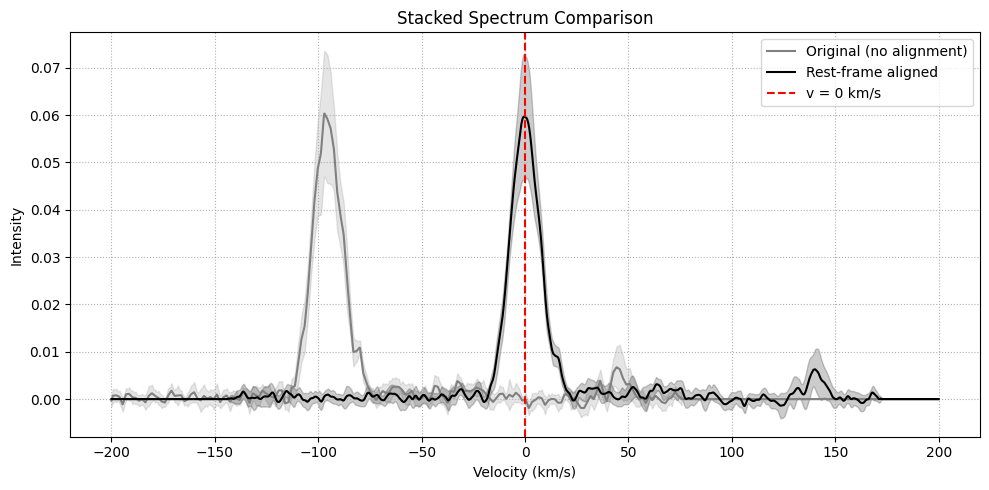

‚úÖ Stacking comparison complete. Used 98 spectra.


In [20]:
def compare_stack_with_without_shift(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    v_range=(-50, 50),
    dv=0.2,
    normalize=False,
    min_valid_spectra=30
):
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d

    # === ËÆÄÂèñË≥áÊñô ===
    with open(data_pickle, 'rb') as f:
        data = pickle.load(f)
    with open(result_pickle, 'rb') as f:
        result = pickle.load(f)

    x_all = data['x_values']
    y_all = data['data_list']
    amps_all = result['amplitudes_fit']
    means_all = result['means_fit']

    # === Âª∫Á´ãÈÄüÂ∫¶Á∂≤Ê†º ===
    v_grid = np.arange(v_range[0], v_range[1] + dv, dv)
    stacked_shifted, stacked_direct = [], []
    used_count = 0

    for x, y, amps, means in zip(x_all, y_all, amps_all, means_all):
        if amps is None or means is None or len(amps) == 0:
            continue

        try:
            idx_peak = np.argmax(amps)
            v_peak = means[idx_peak]

            # --- Â∞çÈΩäÂæå ---
            x_shifted = x - v_peak
            interp_shifted = interp1d(x_shifted, y, kind='linear', bounds_error=False, fill_value=0)
            y_shifted = interp_shifted(v_grid)
            if normalize:
                max_val = np.nanmax(np.abs(y_shifted))
                if max_val > 0:
                    y_shifted /= max_val
            stacked_shifted.append(y_shifted)

            # --- Êú™Â∞çÈΩä ---
            interp_direct = interp1d(x, y, kind='linear', bounds_error=False, fill_value=0)
            y_direct = interp_direct(v_grid)
            if normalize:
                max_val = np.nanmax(np.abs(y_direct))
                if max_val > 0:
                    y_direct /= max_val
            stacked_direct.append(y_direct)

            used_count += 1
        except Exception:
            continue

    # === ËΩâÁÇ∫ numpy Èô£Âàó ===
    stacked_shifted = np.array(stacked_shifted)
    stacked_direct = np.array(stacked_direct)

    # === ÊúâÊïàÂçÄÈñìÈÅÆÁΩ© ===
    valid_counts = np.sum(~np.isnan(stacked_shifted), axis=0)
    valid_mask = valid_counts >= min_valid_spectra
    v_grid_valid = v_grid[valid_mask]

    mean_shifted = np.nanmean(stacked_shifted[:, valid_mask], axis=0)
    std_shifted = np.nanstd(stacked_shifted[:, valid_mask], axis=0)

    mean_direct = np.nanmean(stacked_direct[:, valid_mask], axis=0)
    std_direct = np.nanstd(stacked_direct[:, valid_mask], axis=0)

    # === Áπ™Âúñ ===
    plt.figure(figsize=(10, 5))
    plt.plot(v_grid_valid, mean_direct, label='Original (no alignment)', color='gray', linestyle='-')
    plt.fill_between(v_grid_valid, mean_direct - std_direct, mean_direct + std_direct, color='gray', alpha=0.2)

    plt.plot(v_grid_valid, mean_shifted, label='Rest-frame aligned', color='black')
    plt.fill_between(v_grid_valid, mean_shifted - std_shifted, mean_shifted + std_shifted, color='black', alpha=0.2)

    plt.axvline(0, linestyle='--', color='red', label='v = 0 km/s')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity')
    plt.title('Stacked Spectrum Comparison')
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"‚úÖ Stacking comparison complete. Used {used_count} spectra.")

    return
        # 'v_grid': v_grid_valid,
        # 'mean_shifted': mean_shifted,
        # 'std_shifted': std_shifted,
        # 'mean_direct': mean_direct,
        # 'std_direct': std_direct,
        # 'used_count': used_count
    

compare_stack_with_without_shift(
    data_pickle='spectrum_for_gausspy.pickle',
    result_pickle='gausspy_result.pickle',
    v_range=(-200,200),
    dv=0.2,
    normalize=False,
    min_valid_spectra=30
)

Prepared 400 spectra ‚Üí spectrum_for_gausspy.pickle
Running GaussPy phase-two decomposition ...
using 6 out of 8 cpus
   ---->   0
   ---->   1   ---->  

  0%|          | 0.00/399 [00:00<?, ?it/s]

   ---->  
   ---->     32   ---->     ---->  
4
  
65

   ---->  

  0%|          | 1.00/399 [00:00<02:15, 2.93it/s]

 7
   ---->   8   ---->  
 9


  1%|          | 4.00/399 [00:00<00:36, 10.7it/s]

   ---->   10
   ---->     ---->    11
12


  2%|‚ñè         | 7.00/399 [00:00<00:41, 9.37it/s]

   ---->   13
   ---->   14
   ---->   15
   ---->   16
   ---->   17


  3%|‚ñé         | 12.0/399 [00:00<00:22, 17.2it/s]

   ---->   18
   ---->   19
   ---->   20


  4%|‚ñç         | 15.0/399 [00:01<00:31, 12.4it/s]

   ---->   21
   ---->   22
   ---->   23
   ---->   24


  5%|‚ñç         | 19.0/399 [00:01<00:30, 12.6it/s]

   ---->   25
   ---->   26
   ---->   27


  6%|‚ñå         | 22.0/399 [00:01<00:26, 14.2it/s]

   ---->   28
   ---->   29
   ---->   30


  6%|‚ñã         | 25.0/399 [00:02<00:29, 12.6it/s]

   ---->   31
   ---->   32
   ---->   33


  7%|‚ñã         | 28.0/399 [00:02<00:24, 15.0it/s]

   ---->   34
   ---->   35


  8%|‚ñä         | 30.0/399 [00:02<00:23, 15.5it/s]

   ---->   36
   ---->   37


  8%|‚ñä         | 32.0/399 [00:02<00:27, 13.1it/s]

   ---->   38
   ---->   39
   ---->   40
   ---->   41
   ---->  

  9%|‚ñâ         | 36.0/399 [00:02<00:20, 17.6it/s]

 42
   ---->   43
   ---->   44
   ---->  

 10%|‚ñâ         | 39.0/399 [00:02<00:24, 14.6it/s]

 45
   ---->   46
   ---->   47
   ---->  

 11%|‚ñà         | 42.0/399 [00:02<00:20, 17.3it/s]

 48
   ---->   49
   ---->   50
   ---->  

 11%|‚ñà‚ñè        | 45.0/399 [00:03<00:26, 13.3it/s]

 51
   ---->   52
   ---->   53
   ---->   54


 12%|‚ñà‚ñè        | 49.0/399 [00:03<00:24, 14.1it/s]

   ---->   55
   ---->   56
   ---->  

 13%|‚ñà‚ñé        | 51.0/399 [00:03<00:23, 14.6it/s]

 57
   ---->   58
   ---->   59
   ---->  

 14%|‚ñà‚ñé        | 54.0/399 [00:03<00:20, 16.6it/s]

 60
   ---->   61


 14%|‚ñà‚ñç        | 56.0/399 [00:04<00:25, 13.6it/s]

   ---->   62
   ---->   63
   ---->   64
   ---->   65


 15%|‚ñà‚ñå        | 60.0/399 [00:04<00:19, 17.0it/s]

   ---->   66
   ---->   67


 16%|‚ñà‚ñå        | 62.0/399 [00:04<00:23, 14.2it/s]

   ---->   68
   ---->   69
   ---->   70
   ---->   71


 17%|‚ñà‚ñã        | 66.0/399 [00:04<00:20, 16.2it/s]

   ---->   72
   ---->   73
   ---->  

 17%|‚ñà‚ñã        | 68.0/399 [00:04<00:25, 13.1it/s]

 74
   ---->   75
   ---->   76
   ---->   77
   ---->  

 18%|‚ñà‚ñä        | 72.0/399 [00:05<00:22, 14.2it/s]

 78
   ---->   79


 19%|‚ñà‚ñä        | 74.0/399 [00:05<00:23, 14.1it/s]

   ---->   80
   ---->   81
   ---->   82
   ---->   83


 20%|‚ñà‚ñâ        | 78.0/399 [00:05<00:21, 14.7it/s]

   ---->   84
   ---->   85


 20%|‚ñà‚ñà        | 80.0/399 [00:05<00:21, 14.9it/s]

   ---->   86
   ---->   87
   ---->   88
   ---->   89


 21%|‚ñà‚ñà        | 84.0/399 [00:05<00:22, 14.1it/s]

   ---->   90   ---->  
 91


 22%|‚ñà‚ñà‚ñè       | 86.0/399 [00:06<00:21, 14.7it/s]

   ---->   92
   ---->   93
   ---->   94


 22%|‚ñà‚ñà‚ñè       | 89.0/399 [00:06<00:18, 17.1it/s]

   ---->   95
   ---->   96
   ---->  

 23%|‚ñà‚ñà‚ñé       | 91.0/399 [00:06<00:23, 13.1it/s]

 97
   ---->   98


 23%|‚ñà‚ñà‚ñé       | 93.0/399 [00:06<00:23, 13.2it/s]

   ---->      ---->  99 
100
   ---->   101
   ---->  

 24%|‚ñà‚ñà‚ñç       | 96.0/399 [00:06<00:24, 12.1it/s]

    ---->  102 103

   ---->   104


 25%|‚ñà‚ñà‚ñç       | 99.0/399 [00:07<00:21, 13.7it/s]

   ---->   105
   ---->   106
   ---->   107
   ---->  

 26%|‚ñà‚ñà‚ñå       | 102/399 [00:07<00:22, 13.2it/s] 

 108
   ---->   109


 26%|‚ñà‚ñà‚ñå       | 104/399 [00:07<00:21, 13.6it/s]

   ---->   110
   ---->   111


 27%|‚ñà‚ñà‚ñã       | 106/399 [00:07<00:21, 13.8it/s]

   ---->   112
   ---->   113
   ---->  

 27%|‚ñà‚ñà‚ñã       | 108/399 [00:07<00:22, 13.1it/s]

 114
   ---->   115
   ---->   116
   ---->  

 28%|‚ñà‚ñà‚ñä       | 111/399 [00:07<00:18, 15.9it/s]

 117
   ---->   118
   ---->  

 28%|‚ñà‚ñà‚ñä       | 113/399 [00:07<00:18, 15.8it/s]

 119
   ---->   120
   ---->  

 29%|‚ñà‚ñà‚ñâ       | 115/399 [00:08<00:19, 14.4it/s]

 121
   ---->   122


 29%|‚ñà‚ñà‚ñâ       | 117/399 [00:08<00:26, 10.6it/s]

   ---->   123
   ---->   124
   ---->   125


 30%|‚ñà‚ñà‚ñà       | 120/399 [00:08<00:26, 10.7it/s]

   ---->   126
   ---->   127
   ---->   128
   ---->  

 31%|‚ñà‚ñà‚ñà       | 123/399 [00:08<00:22, 12.4it/s]

 129
   ---->   130
   ---->   131


 32%|‚ñà‚ñà‚ñà‚ñè      | 126/399 [00:09<00:21, 12.7it/s]

   ---->   132
   ---->   133


 32%|‚ñà‚ñà‚ñà‚ñè      | 128/399 [00:09<00:20, 13.5it/s]

   ---->   134
   ---->   135


 33%|‚ñà‚ñà‚ñà‚ñé      | 130/399 [00:09<00:19, 14.0it/s]

   ---->   136
   ---->   137


 33%|‚ñà‚ñà‚ñà‚ñé      | 132/399 [00:09<00:20, 12.9it/s]

   ---->   138
   ---->   139


 34%|‚ñà‚ñà‚ñà‚ñé      | 134/399 [00:09<00:19, 13.7it/s]

   ---->   140
   ---->   141


 34%|‚ñà‚ñà‚ñà‚ñç      | 136/399 [00:09<00:18, 14.4it/s]

   ---->   142
   ---->   143


 35%|‚ñà‚ñà‚ñà‚ñç      | 138/399 [00:10<00:32, 8.12it/s]

   ---->   144
   ---->   145   ---->  
 146


 35%|‚ñà‚ñà‚ñà‚ñå      | 141/399 [00:10<00:26, 9.64it/s]

   ---->   147
   ---->   148
   ---->   149
   ---->  

 36%|‚ñà‚ñà‚ñà‚ñå      | 144/399 [00:10<00:22, 11.1it/s]

 150
   ---->   151
   ---->   152


 37%|‚ñà‚ñà‚ñà‚ñã      | 147/399 [00:10<00:21, 11.9it/s]

   ---->   153
   ---->   154


 37%|‚ñà‚ñà‚ñà‚ñã      | 149/399 [00:11<00:20, 12.0it/s]

   ---->   155
   ---->   156
   ---->      ---->  157 
158
   ---->  

 38%|‚ñà‚ñà‚ñà‚ñä      | 153/399 [00:11<00:19, 12.8it/s]

 159
   ---->   160
   ---->  

 39%|‚ñà‚ñà‚ñà‚ñâ      | 155/399 [00:11<00:18, 13.0it/s]

 161
   ---->   162


 39%|‚ñà‚ñà‚ñà‚ñâ      | 157/399 [00:11<00:24, 10.1it/s]

   ---->   163
   ---->   164
   ---->  

 40%|‚ñà‚ñà‚ñà‚ñâ      | 159/399 [00:12<00:27, 8.83it/s]

 165
   ---->   166
   ---->   167


 41%|‚ñà‚ñà‚ñà‚ñà      | 162/399 [00:12<00:21, 11.1it/s]

   ---->   168   ---->   
169


 41%|‚ñà‚ñà‚ñà‚ñà      | 164/399 [00:12<00:20, 11.5it/s]

   ---->   170
   ---->   171


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 166/399 [00:12<00:20, 11.2it/s]

   ---->   172
   ---->   173
   ---->   174
   ---->   175


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 170/399 [00:12<00:17, 13.1it/s]

   ---->   176
   ---->   177

 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 172/399 [00:13<00:17, 13.1it/s]

   ---->  
 178
   ---->   179


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 174/399 [00:13<00:15, 14.1it/s]

   ---->   180
   ---->   181


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 176/399 [00:13<00:22, 9.74it/s]

   ---->   182
   ---->     ---->    183184



 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 179/399 [00:13<00:22, 9.61it/s]

   ---->     ---->    185186



 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 181/399 [00:14<00:20, 10.7it/s]

   ---->   187
   ---->   188
   ---->   189
   ---->   190


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 185/399 [00:14<00:19, 11.1it/s]

   ---->   191   ---->   
192
   ---->   193
   ---->   194


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 189/399 [00:14<00:13, 15.1it/s]

   ---->   195
   ---->   196


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 191/399 [00:14<00:18, 11.5it/s]

   ---->   197
   ---->   198
   ---->   199
   ---->   200


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 195/399 [00:14<00:13, 15.3it/s]

   ---->   201
   ---->   202
   ---->   203


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 198/399 [00:15<00:17, 11.4it/s]

   ---->   204
   ---->   205


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 200/399 [00:15<00:18, 11.0it/s]

   ---->   206
   ---->   207
   ---->  

 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 202/399 [00:15<00:16, 12.0it/s]

 208
   ---->   209


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 204/399 [00:15<00:16, 11.9it/s]

   ---->   210
   ---->   211


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 206/399 [00:16<00:16, 11.5it/s]

   ---->   212
   ---->   213


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 208/399 [00:16<00:16, 11.8it/s]

   ---->   214
   ---->   215
   ---->  

 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 210/399 [00:16<00:14, 13.0it/s]

 216
   ---->   217
   ---->  

 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 212/399 [00:16<00:14, 13.0it/s]

 218
   ---->   219
   ---->  

 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 214/399 [00:16<00:15, 12.2it/s]

 220
   ---->   221


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 216/399 [00:16<00:15, 11.8it/s]

   ---->   222
   ---->   223


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 218/399 [00:17<00:16, 10.8it/s]

   ---->   224
   ---->   225
   ---->   226
   ---->  

 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 221/399 [00:17<00:14, 12.3it/s]

 227
   ---->   228


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 223/399 [00:17<00:17, 10.3it/s]

   ---->   229
   ---->   230
   ---->   231
   ---->  

 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 226/399 [00:17<00:13, 12.6it/s]

 232
   ---->   233
   ---->   234


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 229/399 [00:17<00:14, 11.9it/s]

   ---->   235
   ---->   236
   ---->  

 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 231/399 [00:18<00:12, 13.1it/s]

 237
   ---->   238   ---->  
 239


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 234/399 [00:18<00:10, 15.2it/s]

   ---->   240
   ---->   241


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 236/399 [00:18<00:15, 10.7it/s]

   ---->   242
   ---->   243
   ---->   244


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 239/399 [00:18<00:12, 12.7it/s]

   ---->   245
   ---->   246


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 241/399 [00:18<00:12, 12.8it/s]

   ---->   247
   ---->   248
   ---->  

 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 243/399 [00:19<00:13, 11.2it/s]

 249
   ---->   250


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 245/399 [00:19<00:12, 12.6it/s]

   ---->   251
   ---->   252


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 247/399 [00:19<00:11, 12.8it/s]

   ---->   253
   ---->   254
   ---->  

 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 249/399 [00:19<00:11, 12.5it/s]

 255
   ---->   256


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 251/399 [00:19<00:11, 13.2it/s]

   ---->   257
   ---->   258


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 253/399 [00:19<00:10, 14.5it/s]

   ---->   259
   ---->   260


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 255/399 [00:19<00:11, 12.7it/s]

   ---->   261
   ---->   262


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 257/399 [00:20<00:15, 9.42it/s]

   ---->   263
   ---->   264
   ---->  

 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 259/399 [00:20<00:12, 11.0it/s]

 265
   ---->   266
   ---->  

 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 261/399 [00:20<00:11, 12.1it/s]

 267
   ---->   268
   ---->  

 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 263/399 [00:20<00:13, 10.3it/s]

 269
   ---->   270


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 265/399 [00:20<00:11, 11.6it/s]

   ---->   271
   ---->   272


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 267/399 [00:21<00:10, 13.2it/s]

   ---->   273
   ---->   274


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 269/399 [00:21<00:10, 11.9it/s]

   ---->   275
   ---->   276
   ---->  

 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 271/399 [00:21<00:10, 12.2it/s]

 277
   ---->   278
   ---->   279


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 274/399 [00:21<00:08, 15.1it/s]

   ---->   280
   ---->   281


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 276/399 [00:21<00:11, 10.7it/s]

   ---->   282
   ---->   283
   ---->  

 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 278/399 [00:22<00:12, 9.67it/s]

 284
   ---->   285
   ---->   286


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 281/399 [00:22<00:09, 11.9it/s]

   ---->   287
   ---->   288
   ---->  

 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 283/399 [00:22<00:10, 11.1it/s]

 289
   ---->   290


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 285/399 [00:22<00:10, 10.8it/s]

   ---->   291
   ---->   292
   ---->   293


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 288/399 [00:22<00:07, 14.1it/s]

   ---->   294
   ---->   295
   ---->  

 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 290/399 [00:23<00:09, 11.9it/s]

 296
   ---->   297


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 292/399 [00:23<00:08, 12.4it/s]

   ---->   298
   ---->   299
   ---->   300


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 295/399 [00:23<00:07, 13.9it/s]

   ---->   301
   ---->   302

 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 297/399 [00:23<00:10, 9.85it/s]

   ---->  
 303
   ---->   304
   ---->   305
   ---->  

 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 300/399 [00:23<00:08, 11.0it/s]

 306
   ---->   307


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 302/399 [00:24<00:09, 10.5it/s]

   ---->   308
   ---->   309


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 304/399 [00:24<00:08, 11.4it/s]

   ---->   310
   ---->   311


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 306/399 [00:24<00:07, 11.8it/s]

   ---->   312
   ---->   313
   ---->  

 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 308/399 [00:24<00:08, 11.1it/s]

 314
   ---->   315
   ---->   316
   ---->  

 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 311/399 [00:24<00:06, 13.5it/s]

 317
   ---->   318


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 313/399 [00:24<00:06, 13.2it/s]

   ---->   319
   ---->   320


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 315/399 [00:25<00:07, 11.8it/s]

   ---->   321
   ---->   322


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 317/399 [00:25<00:09, 8.89it/s]

   ---->   323
   ---->   324
   ---->  

 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 319/399 [00:25<00:08, 9.69it/s]

 325
   ---->   326


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 321/399 [00:25<00:07, 10.8it/s]

   ---->   327
   ---->   328


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 323/399 [00:26<00:07, 10.5it/s]

   ---->   329
   ---->   330


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 325/399 [00:26<00:06, 11.2it/s]

   ---->   331
   ---->   332


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 327/399 [00:26<00:06, 11.3it/s]

   ---->   333
   ---->   334


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 329/399 [00:26<00:05, 12.5it/s]

   ---->   335
   ---->   336


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 331/399 [00:26<00:05, 12.1it/s]

   ---->   337
   ---->   338


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 333/399 [00:26<00:05, 11.9it/s]

   ---->   339
   ---->   340


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 335/399 [00:27<00:07, 8.70it/s]

   ---->   341
   ---->   342


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 337/399 [00:27<00:07, 7.86it/s]

   ---->   343
   ---->   344


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 339/399 [00:27<00:06, 9.04it/s]

   ---->   345
   ---->   346


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 341/399 [00:27<00:06, 9.27it/s]

   ---->   347
   ---->   348


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 343/399 [00:28<00:05, 10.0it/s]

   ---->   349
   ---->   350
   ---->  

 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 345/399 [00:28<00:05, 10.2it/s]

    ---->  351
 352
   ---->   353


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 348/399 [00:28<00:03, 13.3it/s]

   ---->   354
   ---->   355
   ---->  

 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 350/399 [00:28<00:04, 11.4it/s]

 356
   ---->   357


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 352/399 [00:28<00:03, 12.9it/s]

   ---->   358
   ---->   359


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 354/399 [00:28<00:03, 14.0it/s]

   ---->   360
   ---->   361
   ---->  

 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 356/399 [00:29<00:04, 8.62it/s]

 362
   ---->   363


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 358/399 [00:29<00:05, 7.45it/s]

   ---->   364
   ---->   365
   ---->   366
   ---->  

 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 361/399 [00:29<00:03, 10.4it/s]

 367
   ---->   368


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 363/399 [00:29<00:03, 9.26it/s]

   ---->   369
   ---->   370


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 365/399 [00:30<00:03, 10.2it/s]

   ---->     ---->    372371

   ---->   373
   ---->   374


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 369/399 [00:30<00:02, 11.1it/s]

   ---->   375
   ---->   376


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 371/399 [00:30<00:02, 11.9it/s]

   ---->   377
   ---->     ---->    379378

   ---->   380


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 375/399 [00:30<00:02, 11.9it/s]

   ---->   381
   ---->   382


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 377/399 [00:31<00:01, 12.0it/s]

   ---->   383   ---->   
384
   ---->   385


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 380/399 [00:31<00:01, 11.9it/s]

   ---->   386
   ---->   387
   ---->     ---->  

 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 382/399 [00:31<00:01, 11.2it/s]

  388389

   ---->   390
   ---->   391


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 386/399 [00:31<00:01, 11.8it/s]

   ---->   392
   ---->   393


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 388/399 [00:31<00:00, 12.1it/s]

   ---->   394
   ---->   395
   ---->   396


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 391/399 [00:32<00:00, 15.0it/s]

   ---->   397
   ---->   398


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 393/399 [00:32<00:00, 12.5it/s]

   ---->   399


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 399/399 [00:32<00:00, 12.2it/s]
399it [00:00, 852535.56it/s]

SUCCESS
100 finished.%
GaussPy decomposition finished ‚Üí gausspy_result.pickle
Result keys: ['index_fit', 'amplitudes_fit', 'fwhms_fit', 'means_fit', 'index_initial', 'amplitudes_initial', 'fwhms_initial', 'means_initial', 'amplitudes_fit_err', 'fwhms_fit_err', 'means_fit_err', 'best_fit_rchi2', 'amplitudes_fit_em', 'fwhms_fit_em', 'means_fit_em', 'means_fit_err_em', 'amplitudes_fit_err_em', 'fwhms_fit_err_em', 'fit_labels']
Total: 400, Success: 296, Failed: 104
Success rate: 74.0%


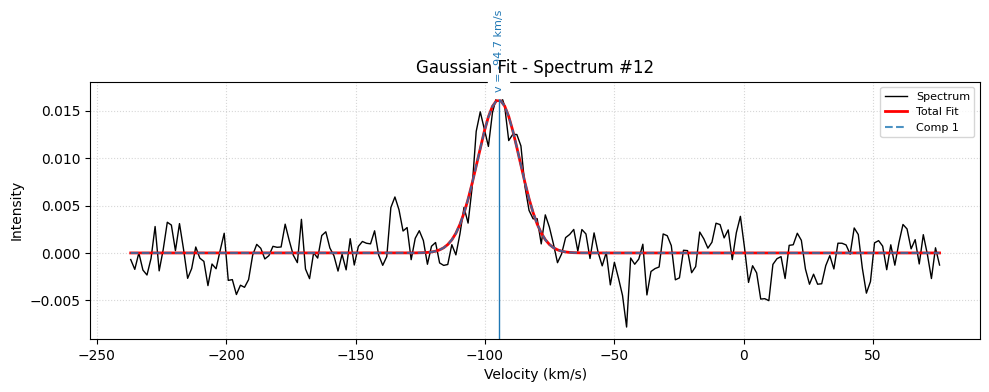

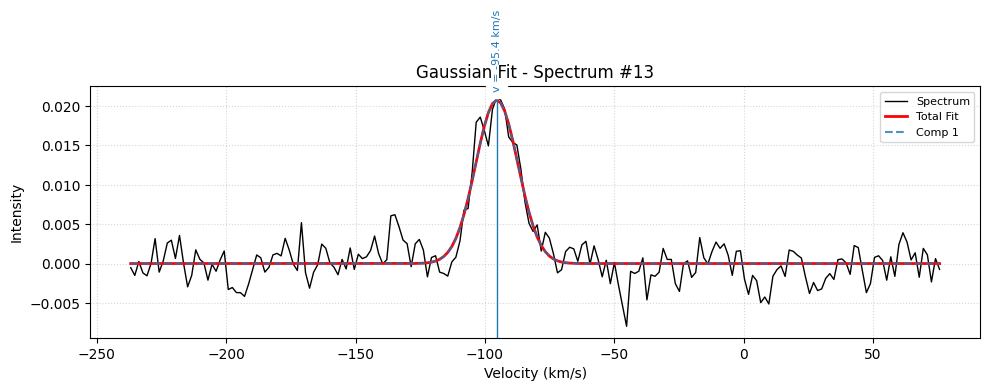

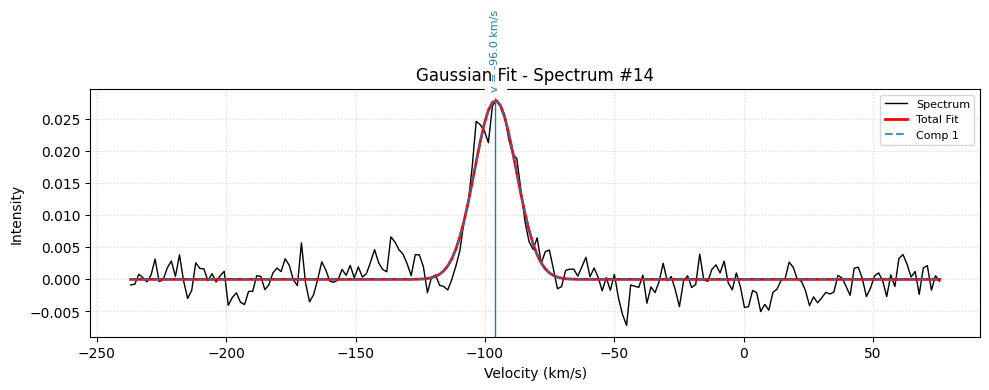

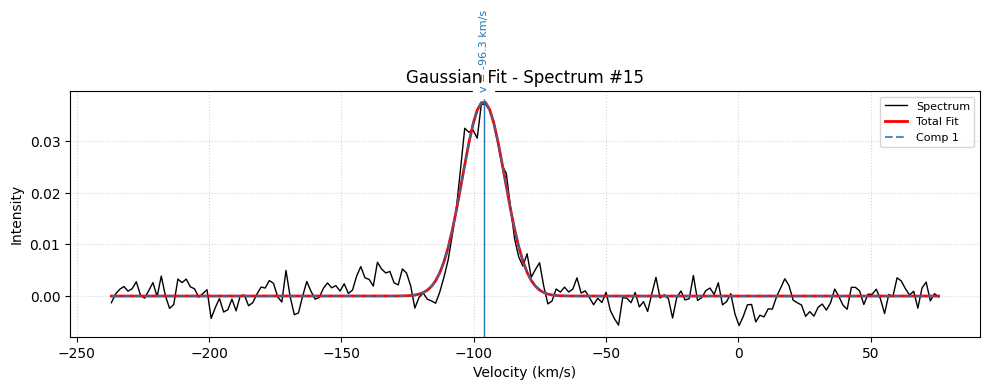

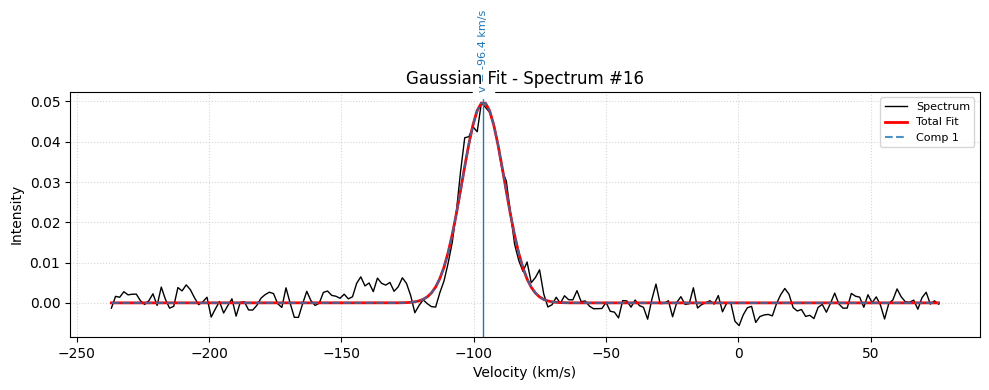

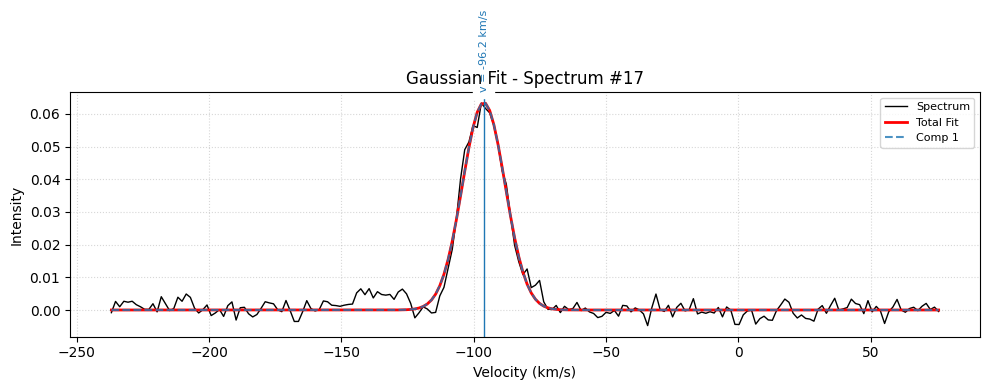

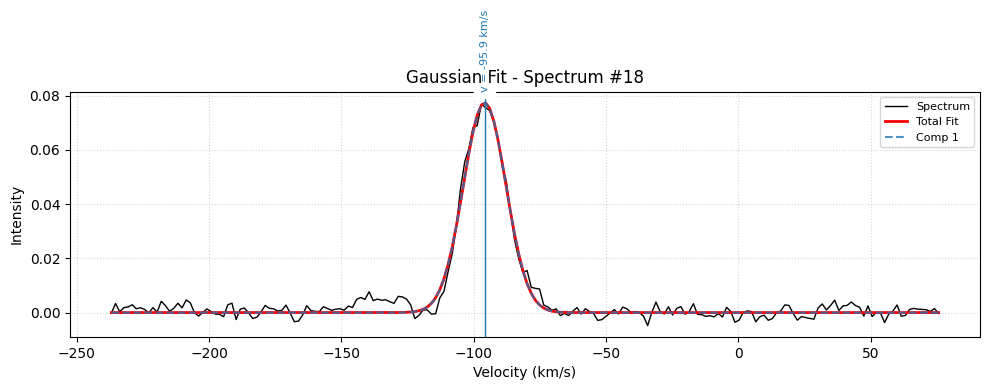

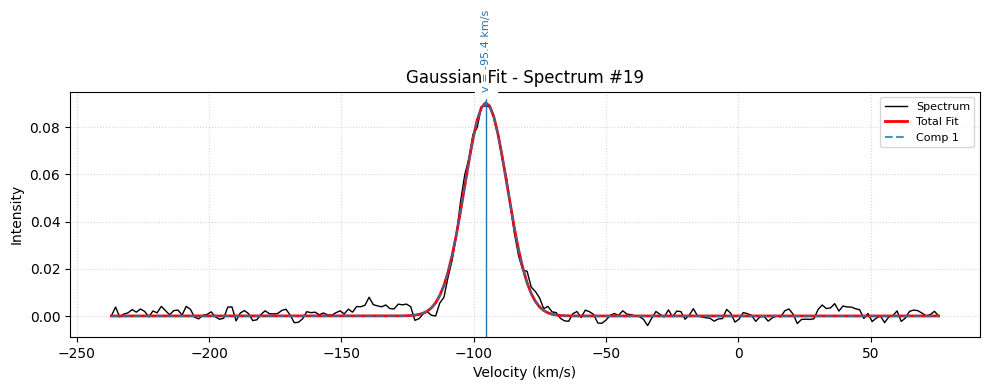

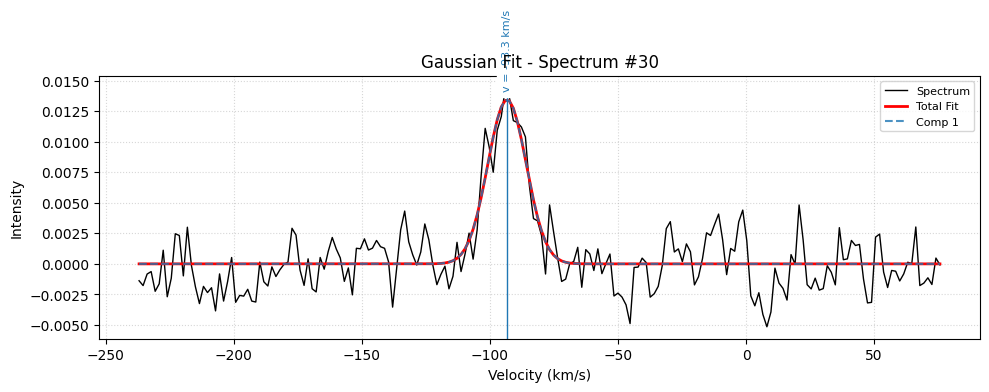

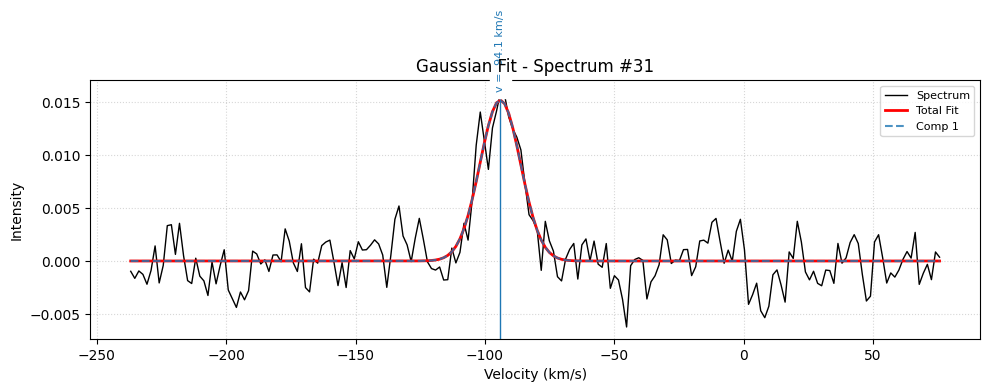

Plotted 10 fitted spectra.


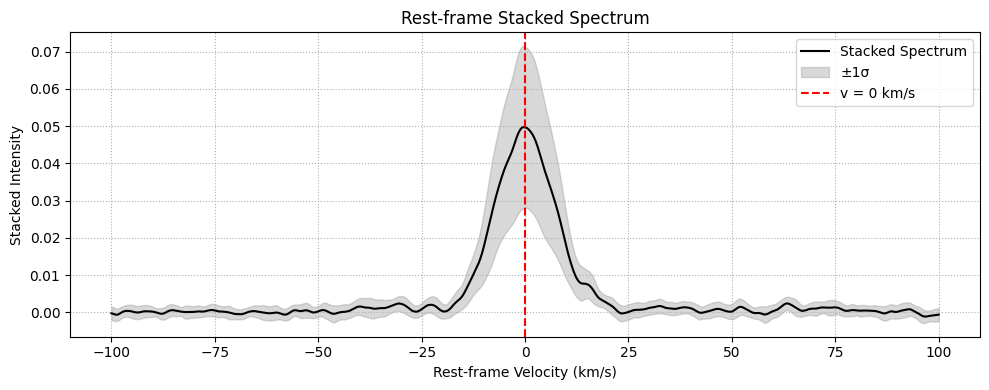

Stacking done: 296/400 spectra used (74.0%)


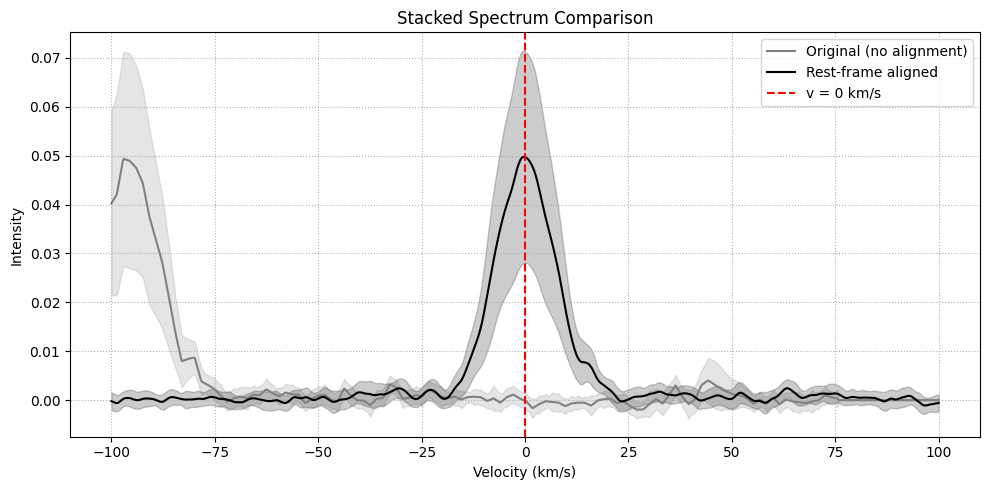

Stacking comparison done. Used 296 spectra.


In [5]:
from gausspy_pipeline import GausspyPipeline

# ‰æùÊìö‰Ω†ÁöÑË≥áÊñôË®≠ÂÆö‰∏ãÂàóÂèÉÊï∏
pipeline = GausspyPipeline(
    cube_file='../datacubes/spw0.fits',    # ‰Ω†ÁöÑ FITS Ê™îÊ°à
    v1=750, v2=950,           # È†ªÈÅìÁØÑÂúç
    x1=220, x2=240,           # x Á©∫ÈñìÁØÑÂúç
    y1=100, y2=120,           # y Á©∫ÈñìÁØÑÂúç
    alpha1=2.5,
    alpha2=7.0,
    snr_thresh=4.0
)

# Step 1: Ê∫ñÂÇô spectra pickle
pipeline.prepare_input()

# Step 2: Ë∑ë GaussPy decomposition
pipeline.run_decomposition()

# Step 3: Áµ±Ë®àÂàÜËß£ÊàêÊïà
pipeline.count_fits()

# Step 4: Áπ™Ë£ΩÈÉ®ÂàÜÊì¨ÂêàÂúñÔºàÈ†êË®≠ÊúÄÂ§ö10Ê¢ùÔºâ
pipeline.plot_fits()

# Step 5: Rest-frame ÁñäÂä†ÂàÜÊûê„ÄÅÁπ™Âúñ
pipeline.stack_restframe()

# Step 6: ÁñäÂä†ÊØîËºÉÔºàÂèØÁúÅÁï•Ôºâ
pipeline.compare_stack()
